# Trabalho Udacity - Usando notícias para prever o movimento de ações

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import sys
import os
import os.path
import random
from pathlib import Path
from time import time
from itertools import chain
from kaggle.competitions import twosigmanews

import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, make_scorer
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer,StandardScaler, MinMaxScaler,OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization, LSTM, Embedding
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
import tensorflow

# Charts
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

Using TensorFlow backend.


In [2]:
# get the data from two sigma environment
env = twosigmanews.make_env()
(market_train_df, news_train_df) = env.get_training_data()

Loading the data... This could take a minute.
Done!


In [3]:
market_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072956 entries, 0 to 4072955
Data columns (total 16 columns):
time                        datetime64[ns, UTC]
assetCode                   object
assetName                   category
volume                      float64
close                       float64
open                        float64
returnsClosePrevRaw1        float64
returnsOpenPrevRaw1         float64
returnsClosePrevMktres1     float64
returnsOpenPrevMktres1      float64
returnsClosePrevRaw10       float64
returnsOpenPrevRaw10        float64
returnsClosePrevMktres10    float64
returnsOpenPrevMktres10     float64
returnsOpenNextMktres10     float64
universe                    float64
dtypes: category(1), datetime64[ns, UTC](1), float64(13), object(1)
memory usage: 474.1+ MB


In [4]:
news_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9328827 entries, 0 to 9328826
Data columns (total 35 columns):
time                    datetime64[ns, UTC]
sourceTimestamp         datetime64[ns, UTC]
firstCreated            datetime64[ns, UTC]
sourceId                object
headline                object
urgency                 int8
takeSequence            int16
provider                category
subjects                category
audiences               category
bodySize                int32
companyCount            int8
headlineTag             object
marketCommentary        bool
sentenceCount           int16
wordCount               int32
assetCodes              category
assetName               category
firstMentionSentence    int16
relevance               float32
sentimentClass          int8
sentimentNegative       float32
sentimentNeutral        float32
sentimentPositive       float32
sentimentWordCount      int32
noveltyCount12H         int16
noveltyCount24H         int16
noveltyCount3

In [5]:
market_train_df['close_to_open'] =  np.abs(market_train_df['close'] / market_train_df['open'])

In [6]:
print(f"In {(market_train_df['close_to_open'] >= 2).sum()} lines price increased by 100% or more.")
print(f"In {(market_train_df['close_to_open'] <= 0.5).sum()} lines price decreased by 100% or more.")

In 38 lines price increased by 100% or more.
In 16 lines price decreased by 100% or more.


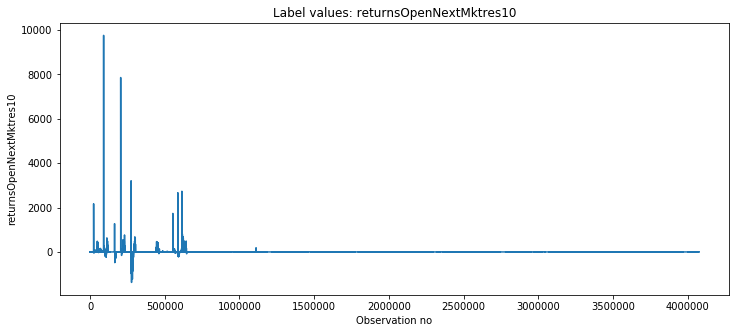

count    4.072956e+06
mean     1.405528e-02
std      7.242467e+00
min     -1.375045e+03
1%      -1.888052e-01
50%      1.044642e-03
99%      2.078779e-01
max      9.761338e+03
Name: returnsOpenNextMktres10, dtype: float64

In [7]:
# Plot label column
market_train_df.returnsOpenNextMktres10.plot(figsize=(12,5))
plt.title('Label values: returnsOpenNextMktres10')
plt.ylabel('returnsOpenNextMktres10')
plt.xlabel('Observation no')
plt.show()

# Look at quantiles
market_train_df.returnsOpenNextMktres10.describe(percentiles=[0.01, 0.99])

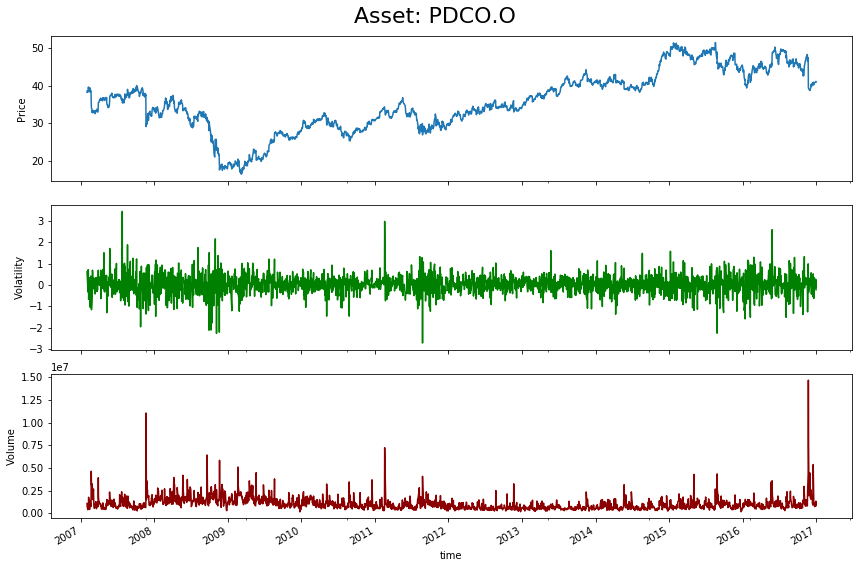

In [8]:
def plot_random_asset(market):
    """
    Get random asset, show price, volatility and volume
    """
    # Get any asset
    ass = market.assetCode.sample(1, random_state=24).iloc[0]
    ass_market = market[market['assetCode'] == ass]
    ass_market.index = ass_market.time

    # Plotting
    f, axs = plt.subplots(3,1, sharex=True, figsize=(12,8))
    # Close price 
    ass_market.close.plot(ax=axs[0])
    axs[0].set_ylabel("Price")

    # Volatility (close-open)
    volat_df = (ass_market.close - ass_market.open)
    (ass_market.close - ass_market.open).plot(color='green', ax = axs[1])
    axs[1].set_ylabel("Volatility")

    # Volume
    ass_market.volume.plot(ax=axs[2], color='darkred')
    axs[2].set_ylabel("Volume")

    # Show the plot
    f.suptitle("Asset: %s" % ass, fontsize=22)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

plot_random_asset(market_train_df)

In [9]:
nnews = news_train_df.size
nassets = len(news_train_df.assetName.cat.categories)
print("Total %d news about %d assets" % (nnews, nassets))

Total 326508945 news about 9680 assets


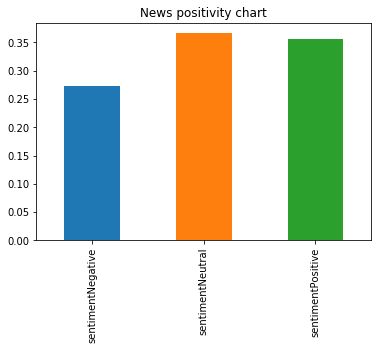

In [10]:
    # Barplot on negative, neutral and positive columns.
    news_train_df[['sentimentNegative', 'sentimentNeutral','sentimentPositive']].mean().plot(kind='bar')
    plt.title("News positivity chart")
    plt.show()

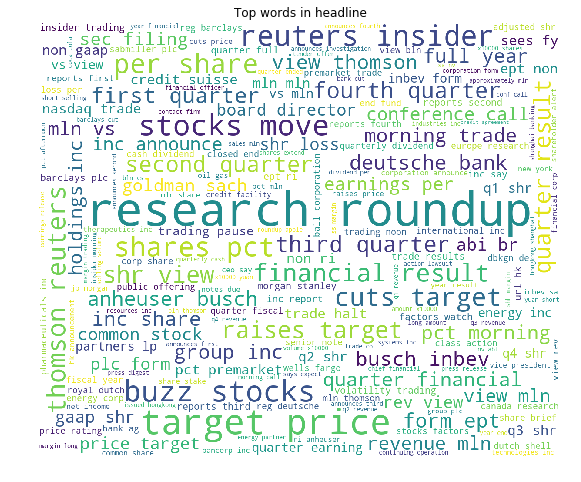

In [11]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

text = ' '.join(news_train_df['headline'].str.lower().values[-1000000:])
wordcloud = WordCloud(max_font_size=None, stopwords=stop, background_color='white',
                      width=1200, height=1000).generate(text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud)
plt.title('Top words in headline')
plt.axis("off")
plt.show()

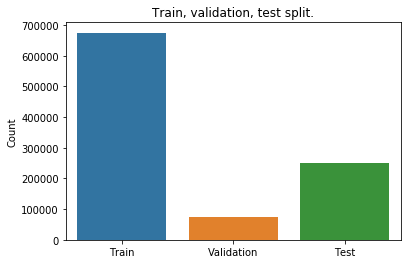

In [12]:
def train_test_val_split(market):
    """
    Get sample of assets but each asset has full market data after 2009
    Split to time sorted train, validation and test.
    @return: train, validation, test df. Short variant - time and asset columns only
    """
    # Work with data after 2009
    market_idx = market[market.time > '2009'][['time', 'assetCode']]
    market_idx = market_idx.sample(1000000)
    # Split to train, validation and test
    market_idx = market_idx.sort_values(by=['time'])
    market_train_idx, market_test_idx = train_test_split(market_idx, shuffle=False, random_state=24)
    market_train_idx, market_val_idx = train_test_split(market_train_idx, test_size=0.1, shuffle=False, random_state=24)
    return(market_train_idx, market_val_idx, market_test_idx)

# Split
train_idx, val_idx, test_idx = train_test_val_split(market_train_df)

# Plot train/val/test size
sns.barplot(['Train', 'Validation', 'Test'],[train_idx.index.size, val_idx.index.size, test_idx.index.size])
plt.title('Train, validation, test split.')
plt.ylabel('Count')
plt.show()

In [13]:
class MarketPrepro:
    """
    Standard way to generate batches for model.fit_generator(generator, ...)
    Should be fit on train data and used on all train, validation, test
    """
    # Features
    assetcode_encoded = []
    time_cols = ['year', 'week', 'day', 'dayofweek']
    numeric_cols = ['volume', 'close', 'open', 'returnsClosePrevRaw1', 'returnsOpenPrevRaw1',
                    'returnsClosePrevMktres1', 'returnsOpenPrevMktres1', 'returnsClosePrevRaw10',
                    'returnsOpenPrevRaw10', 'returnsClosePrevMktres10', 'returnsOpenPrevMktres10']
    feature_cols = ['assetCode_encoded'] + time_cols + numeric_cols

    # Labels
    label_cols = ['returnsOpenNextMktres10']

    def __init__(self):
        self.cats = {}
        self.numeric_scaler = StandardScaler()

    def fit(self, market_train_idx, market):
        """
        Fit preprocessing scalers, encoders on given train df.
        Store given indices to generate batches_from.
        @param market_train_df: train data to fit on
        """
        market_train_df = market.loc[market_train_idx.index].copy()
        # Clean bad data. We fit on train dataset and it's ok to remove bad data
        market_train_df = self.fix_train(market_train_df)

        # Extract day, week, year from time
        market_train_df = self.prepare_time_cols(market_train_df)
        # Fit for numeric and time
        # self.numeric_scaler = QuantileTransformer()
        self.numeric_scaler.fit(market_train_df[self.numeric_cols + self.time_cols])

        # Fit asset encoding
        self.encode_asset(market_train_df, is_train=True)

    def fix_train(self, train_df):
        """
        Remove bad data. For train dataset only
        """
        # Remove strange cases with close/open ratio > 2
        max_ratio = 2
        train_df = train_df[(train_df['close'] / train_df['open']).abs() <= max_ratio].loc[:]
        # Fix outliers etc like for test set
        train_df = self.safe_fix(train_df)
        return train_df

    def safe_fix(self, df):
        """
        Fill na, fix outliers. Safe for test dataset, no rows removed.
        """
        # Fill nans
        df[self.numeric_cols] = df[self.numeric_cols].fillna(0)
        # Fix outliers
        df[self.numeric_cols] = df[self.numeric_cols].clip(df[self.numeric_cols].quantile(0.01),
                                                           df[self.numeric_cols].quantile(0.99), axis=1)
        return df

    def get_X(self, df):
        """
        Preprocess and return X without y
        """
        df = df.copy()
        df = self.safe_fix(df)

        # Add day, week, year
        df = self.prepare_time_cols(df)
        # Encode assetCode
        df = self.encode_asset(df)
        # Scale numeric features and labels

        df = df.set_index(['assetCode', 'time'], drop=False)
        df[self.numeric_cols + self.time_cols] = self.numeric_scaler.transform(
            df[self.numeric_cols + self.time_cols].astype(float))

        # print(df.head())
        # Return X
        return df[self.feature_cols]

    def get_y(self, df, is_raw_y=False):
        if is_raw_y:
            return df[self.label_cols]
        else:
            return (df[self.label_cols] >= 0).astype(float)

    def encode_asset(self, df, is_train=False):
        def encode(assetcode):
            """
            Encode categorical features to numbers
            """
            try:
                # Transform to index of name in stored names list
                index_value = self.assetcode_encoded.index(assetcode) + 1
            except ValueError:
                # If new value, add it to the list and return new index
                self.assetcode_encoded.append(assetcode)
                index_value = len(self.assetcode_encoded)

            # index_value = 1.0/(index_value)
            index_value = index_value / (self.assetcode_train_count + 1)
            return (index_value)

        # Store train assetcode_train_count for use as a delimiter for test data encoding
        if is_train:
            self.assetcode_train_count = len(df['assetCode'].unique()) + 1

        df['assetCode_encoded'] = df['assetCode'].apply(lambda assetcode: encode(assetcode))
        return (df)

    @staticmethod
    def prepare_time_cols(df):
        """
        Extract time parts, they are important for time series
        """
        df['year'] = pd.to_datetime(df['time']).dt.year
        # Maybe remove month because week of year can handle the same info
        df['day'] = pd.to_datetime(df['time']).dt.day
        # Week of year
        df['week'] = pd.to_datetime(df['time']).dt.week
        df['dayofweek'] = pd.to_datetime(df['time']).dt.dayofweek
        return df

    
# Create instance for global usage
market_prepro = MarketPrepro()
market_prepro.fit(train_idx, market_train_df)
print('market_prepro is fit')

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


market_prepro is fit


In [14]:
class NewsPrepro:
    """
    Aggregate news by day and asset. Normalize numeric values.
    """
    news_cols_numeric = ['urgency', 'takeSequence', 'wordCount', 'sentenceCount', 'companyCount',
                         'marketCommentary', 'relevance', 'sentimentNegative', 'sentimentNeutral',
                         'sentimentPositive', 'sentimentWordCount', 'noveltyCount12H', 'noveltyCount24H',
                         'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D', 'volumeCounts12H',
                         'volumeCounts24H', 'volumeCounts3D', 'volumeCounts5D', 'volumeCounts7D']

    feature_cols = news_cols_numeric

    def fit(self, idx, news):
        """
        Fit preprocessing scalers, encoders on given train df.
        @param idx: index with time, assetCode
        """
        # Save indices[assetCode, time, news_index] for all news
        self.all_news_idx = self.news_idx(news)

        # Get news only related to market idx
        news_idx = idx.merge(self.all_news_idx, on=['assetCode', 'time'], suffixes=['_idx', ''])[
            ['news_index', 'assetCode', 'time']]
        news_train_df = news_idx.merge(news, left_on='news_index', right_index=True, suffixes=['_idx', ''])[
            self.news_cols_numeric]

        # Numeric data normalization
        self.numeric_scaler = StandardScaler()
        news_train_df.fillna(0, inplace=True)

        # Fit scaler
        self.numeric_scaler.fit(news_train_df)

    def get_X(self, idx, news):
        """
        Preprocess news for asset code and time from given index
        """
        news_idx = idx.merge(self.all_news_idx, on=['assetCode', 'time'], suffixes=['_idx', ''])[
            ['news_index', 'assetCode', 'time']]
        news_df = news_idx.merge(news, left_on='news_index', right_index=True, suffixes=['_idx', ''])[
            ['time', 'assetCode'] + self.news_cols_numeric]
        news_df = self.aggregate_news(news_df)

        return self.safe_fix(news_df)

    def safe_fix(self, news_df):
        """
        Scale, fillna
        """
        # Normalize, fillna etc without removing rows.
        news_df.fillna(0, inplace=True)
        if not news_df.empty:
            news_df[self.news_cols_numeric] = self.numeric_scaler.transform(news_df[self.news_cols_numeric])
        return news_df

    def news_idx(self, news):
        """
        Get asset code, time -> news id
        :param news:
        :return:
        """

        # Fix asset codes (str -> list)
        asset_codes_list = news['assetCodes'].str.findall(f"'([\w\./]+)'")

        # Expand assetCodes
        assetCodes_expanded = list(chain(*asset_codes_list))

        assetCodes_index = news.index.repeat(asset_codes_list.apply(len))
        assert len(assetCodes_index) == len(assetCodes_expanded)
        df_assetCodes = pd.DataFrame({'news_index': assetCodes_index, 'assetCode': assetCodes_expanded})

        # Create expanded news (will repeat every assetCodes' row)
        #        df_expanded = pd.merge(df_assetCodes, news, left_on='level_0', right_index=True)
        df_expanded = pd.merge(df_assetCodes, news[['time']], left_on='news_index', right_index=True)
        # df_expanded = df_expanded[['time', 'assetCode'] + self.news_cols_numeric].groupby(['time', 'assetCode']).mean()

        return df_expanded

    def with_asset_code(self, news):
        """
        Update news index to be time, assetCode
        :param news:
        :return:
        """
        if news.empty:
            if 'assetCode' not in news.columns:
                news.columns = news.columns + 'assetCode'
            return news

        # Fix asset codes (str -> list)
        news['assetCodesList'] = news['assetCodes'].str.findall(f"'([\w\./]+)'")

        # Expand assetCodes
        assetCodes_expanded = list(chain(*news['assetCodesList']))

        assetCodes_index = news.index.repeat(news['assetCodesList'].apply(len))
        assert len(assetCodes_index) == len(assetCodes_expanded)
        df_assetCodes = pd.DataFrame({'level_0': assetCodes_index, 'assetCode': assetCodes_expanded})

        # Create expanded news (will repeat every assetCodes' row)
        #        df_expanded = pd.merge(df_assetCodes, news, left_on='level_0', right_index=True)
        df_expanded = pd.merge(df_assetCodes, news, left_on='level_0', right_index=True)
        df_expanded = df_expanded[['time', 'assetCode'] + self.news_cols_numeric].groupby(['time', 'assetCode']).mean()

        return df_expanded

    def aggregate_news(self, df):
        """
        News are rare for an asset. We get mean value for 10 days
        :param df:
        :return:
        """
        if df.empty:
            return df

        # News are rare for the asset, so aggregate them by rolling period say 10 days
        rolling_days = 10
        df_aggregated = df.groupby(['assetCode', 'time']).mean().reset_index(['assetCode', 'time'])
        df_aggregated = df_aggregated.groupby('assetCode') \
            .rolling(rolling_days, on='time') \
            .apply(np.mean, raw=False) \
            .reset_index('assetCode')
        #df_aggregated.set_index(['time', 'assetCode'], inplace=True)
        return df_aggregated
    

# Create instance for global usage
news_prepro = NewsPrepro()
news_prepro.fit(train_idx, news_train_df)
print('news_prepro is fit')

news_prepro is fit


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype bool, int8, int16, float32, int32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


In [15]:
class JoinedPreprocessor:
    """
    Join market with news and preprocess
    """

    def __init__(self, market_prepro, news_prepro):
        self.market_prepro = market_prepro
        self.news_prepro = news_prepro

    def get_X(self, market, news):
        """
        Returns preprocessed market + news
        :return: X
        """
        # Market row
        market_X = self.market_prepro.get_X(market)
        # One row in news contains many asset codes. Extend it to news_X with one asset code - one row
        news_idx = self.news_prepro.news_idx(news)
        news_X = self.news_prepro.get_X(news_idx, news)
        #news_X.time = news_X.time.astype('datetime64')
        # X = market X + news X
        X = market_X.merge(news_X, how='left', on=['time', 'assetCode'], left_index=True)
        X = X.fillna(0)
        X = X[self.market_prepro.feature_cols + self.news_prepro.feature_cols]
        return X

    def get_Xy(self, idx, market, news, is_train=False, is_raw_y=False):
        """
        Returns preprocessed features and labels for given indices
        """
        # Get market data for index
        market_df = market.loc[idx.index]
        # We can remove bad data in train
        if is_train:
            market_df = self.market_prepro.fix_train(market_df)
        market_Xy = self.market_prepro.get_X(market_df)
        # Get news data for index
        news_X = self.news_prepro.get_X(idx, news)
        #news_X.time = pd.to_datetime(news_X.time, utc=True)
        #news_X.time = news_X.time.astype('datetime64')
        # Merge and return
        Xy = market_Xy.merge(news_X, how='left', on=['time', 'assetCode'], left_index=True)
        Xy = Xy.fillna(0)
        X = Xy[self.market_prepro.feature_cols + self.news_prepro.feature_cols]
        y = self.market_prepro.get_y(market_df, is_raw_y)

        return X, y

    def with_look_back(self, X, y, look_back, look_back_step):
        """
        Add look back window values to prepare dataset for LSTM
        """
        look_back_fixed = look_back_step * (look_back // look_back_step)
        # Fill look_back rows before first
        first_xrow = X.values[0]
        first_xrow.shape = [1, X.values.shape[1]]
        first_xrows = np.repeat(first_xrow, look_back_fixed, axis=0)
        X_values = np.append(first_xrows, X.values, axis=0)

        if y is not None:
            first_yrow = y.values[0]
            first_yrow.shape = [1, y.values.shape[1]]
            first_yrows = np.repeat(first_yrow, look_back_fixed, axis=0)
            y_values = np.append(first_yrows, y.values, axis=0)

        # for i in range(0, len(X) - look_back + 1):
        X_processed = []
        y_processed = []
        for i in range(look_back_fixed , len(X_values)):
            # Add lookback to X
            x_window = X_values[i - (look_back_fixed//look_back_step)*look_back_step:i+1:look_back_step, :]
            X_processed.append(x_window)
            # If input is X only, we'll not output y
            if y is None:
                continue
            # Add lookback to y
            y_window = y_values[i - (look_back_fixed//look_back_step)*look_back_step:i+1:look_back_step, :]
            y_processed.append(y_window)
        # Return Xy for train/test or X for prediction
        if y is not None:
            #return np.array(X_processed), np.array(y_processed)
            return np.array(X_processed), y.values
        else:
            return np.array(X_processed)

        
prepro = JoinedPreprocessor(market_prepro, news_prepro)    
print('Preprocessor created')

Preprocessor created


In [16]:
class JoinedGenerator:
    """
    Keras standard approach to generage batches for model.fit_generator() call.
    """

    def __init__(self, prepro, idx, market, news):
        """
        @param preprocessor: market and news join preprocessor
        @param market: full loaded market df
        @param news: full loaded news df
        @param index_df: df with assetCode and time of train or validation market data. Batches will be taken from them.
        """
        self.market = market
        self.prepro = prepro
        self.news = news
        self.idx = idx

    def flow_lstm(self, batch_size, is_train, look_back, look_back_step):
        """
        Generate batch data for LSTM NN
        Each cycle in a loop we yield a batch for one training step in epoch.
        """
        while True:
            # Get market indices of random assets, sorted by assetCode, time.
            batch_idx = self.get_random_assets_idx(batch_size)

            # Get X, y data for this batch, containing market and news, but without look back yet
            X, y = self.prepro.get_Xy(batch_idx, self.market, self.news, is_train)
            # Add look back data to X, y
            X, y = self.prepro.with_look_back(X, y, look_back, look_back_step)
            yield X, y

    def get_random_assets_idx(self, batch_size):
        """
        Get random asset and it's last market data indices.
        Repeat for next asset until we reach batch_size.
        """
        asset_codes = self.idx['assetCode'].unique().tolist()

        # Insert first asset
        asset = np.random.choice(asset_codes)
        asset_codes.remove(asset)
        #asset = 'ADBE.O'
        batch_index_df = self.idx[self.idx.assetCode == asset].tail(batch_size)

        return batch_index_df.sort_values(by=['assetCode', 'time'])
        

# Train data generator instance
join_generator = JoinedGenerator(prepro, train_idx, market_train_df, news_train_df)

# Validation data generator instance
val_generator = JoinedGenerator(prepro, val_idx, market_train_df, news_train_df)
print('Generators created')

Generators created


In [28]:
class Optimization:
    """
    hyperparameter optimization
    """
    
    def __init__(self, model, join_generator, val_generator):
        self.model = model
        self.join_generator = join_generator
        self.val_generator = val_generator
    
    def optimize(self):
        parameters = {'batch_size': [10, 100, 200, 1000, 5000],'epochs': [1, 5, 10, 20],'look_back': [10, 50, 90, 100],'look_back_step': [1, 5, 10, 20]}
        
        batch_size=1000
        validation_batch_size=1000
        steps_per_epoch=20
        validation_steps=5
        epochs=20
        look_back=90
        look_back_step=10
        
        scorer = make_scorer(score_func=get_score())
        
        grid_obj = GridSearchCV(self.model, parameters, scoring=scorer)
        
        start = time()
        grid_fit = grid_obj.fit(join_generator.flow_lstm(batch_size=batch_size
                                                                , is_train=True
                                                                , look_back=look_back
                                                                , look_back_step=look_back_step), val_generator.flow_lstm(batch_size=batch_size
                                                                , is_train=True
                                                                , look_back=look_back
                                                                , look_back_step=look_back_step))
        end = time()
        result_time_optimized_model = end - start

        # Get the estimator
        best_clf = grid_fit.best_estimator_
        return(best_clf)
        
otm = Optimization(model, join_generator, val_generator)
best = otm.optimize()
print('The best estimator was: Batch_size = %d, epochs = %d, look_back = %d and look_back_step = %d', best.batch_size, best.epochs, best.look_back, best.look_back_steps)

The best estimator was: Batch_size = 1000, epochs = 20, look_back = 90 and look_back_step = 10


In [17]:
class ModelFactory:
    """
    Generate different models. Actually only one of them is used in the kernel,
    this factory is for experiments when debugging.
    """
    # LSTM look back window size
    look_back=90
    # In windows size look back each look_back_step days
    look_back_step=10

    def lstm_128(input_size):
        model = Sequential()

        model.add(LSTM(units=128, return_sequences=True, input_shape=(None,input_size)))
        model.add(LSTM(units=64, return_sequences=True ))
        model.add(LSTM(units=32, return_sequences=False))

        # Add an output layer
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

        return(model)

    def train(model, join_generator, val_generator):
        weights_file='best_weights.h5'

        # We'll stop training if no improvement after some epochs
        earlystopper = EarlyStopping(patience=5, verbose=1)

        # Low, avg and high scor training will be saved here
        # Save the best model during the traning
        checkpointer = ModelCheckpoint(weights_file
                                       #,monitor='val_acc'
                                       ,verbose=1
                                       ,save_best_only=True
                                       ,save_weights_only=True)

        
        reduce_lr = ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.001)

        # Set fit parameters
        # Rule of thumb: steps_per_epoch = TotalTrainingSamples / TrainingBatchSize
        #                validation_steps = TotalvalidationSamples / ValidationBatchSize
        batch_size=1000
        validation_batch_size=1000
        steps_per_epoch=20
        validation_steps=5
        epochs=20
        look_back=90
        look_back_step=10

        print(f'epochs:{epochs}, steps per epoch: {steps_per_epoch}, validation steps:{validation_steps}')
        print(f'Batch_size:{batch_size}, validation batch size:{validation_batch_size}')

        # Fit
        training = model.fit_generator(join_generator.flow_lstm(batch_size=batch_size
                                                                , is_train=True
                                                                , look_back=look_back
                                                                , look_back_step=look_back_step)
                                       , epochs=epochs
                                       , validation_data=val_generator.flow_lstm(batch_size=validation_batch_size
                                                                                 , is_train=False
                                                                                 , look_back=look_back
                                                                                 , look_back_step=look_back_step)
                                       , steps_per_epoch=steps_per_epoch
                                       , validation_steps=validation_steps
                                       , callbacks=[earlystopper, checkpointer, reduce_lr])
        # Load best weights saved
        model.load_weights(weights_file)
        return training


model = ModelFactory.lstm_128(len(market_prepro.feature_cols) + len(news_prepro.feature_cols))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 128)         84992     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 146,849
Trainable params: 146,849
Non-trainable params: 0
_________________________________________________________________


In [18]:
training = ModelFactory.train(model, join_generator, val_generator)

epochs:20, steps per epoch: 20, validation steps:5
Batch_size:1000, validation batch size:1000
Epoch 1/20
20/20 [==============================] - 275s 14s/step - loss: 0.6953 - acc: 0.5122 - val_loss: 0.6912 - val_acc: 0.4560

Epoch 00001: val_loss improved from inf to 0.69123, saving model to best_weights.h5
Epoch 2/20
20/20 [==============================] - 259s 13s/step - loss: 0.6974 - acc: 0.4515 - val_loss: 0.7026 - val_acc: 0.4118

Epoch 00002: val_loss did not improve from 0.69123
Epoch 3/20
 1/20 [>.............................] - ETA: 4:46 - loss: 0.7028 - acc: 0.4680

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229584). Check your callbacks.
  % delta_t_median)


 2/20 [==>...........................] - ETA: 4:45 - loss: 0.6842 - acc: 0.5575

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116064). Check your callbacks.
  % delta_t_median)


20/20 [==============================] - 269s 13s/step - loss: 0.6968 - acc: 0.5243 - val_loss: 0.6937 - val_acc: 0.5090

Epoch 00003: val_loss did not improve from 0.69123
Epoch 4/20
20/20 [==============================] - 262s 13s/step - loss: 0.6954 - acc: 0.5010 - val_loss: 0.7109 - val_acc: 0.4274

Epoch 00004: val_loss did not improve from 0.69123
Epoch 5/20
20/20 [==============================] - 265s 13s/step - loss: 0.6956 - acc: 0.5084 - val_loss: 0.7049 - val_acc: 0.4223

Epoch 00005: val_loss did not improve from 0.69123
Epoch 6/20
20/20 [==============================] - 260s 13s/step - loss: 0.6937 - acc: 0.5005 - val_loss: 0.6977 - val_acc: 0.4889

Epoch 00006: val_loss did not improve from 0.69123
Epoch 00006: early stopping


In [19]:
class Predictor:
    """
    Predict for test data or real prediction
    """

    def __init__(self, prepro, market_prepro, news_prepro, model, look_back, look_back_step):
        self.prepro = prepro
        self.market_prepro = market_prepro
        self.news_prepro = news_prepro
        self.model = model
        self.look_back = look_back
        self.look_back_step = look_back_step

    def predict(self, market, news):
        """
        Predict from new received market and news data.
        :return: predicted y
        """
        X = self.prepro.get_X(market, news)
        X = self.prepro.with_look_back(X, None, self.look_back, self.look_back_step)
        y = self.model.predict(X) * 2 - 1
        return y

    def predict_idx(self, pred_idx, market, news):
        """
        Predict for test from indices
        :return:
            predicted y, ground truth y
        """
        # Get preprocessed X, y
        X_test, y_test = self.prepro.get_Xy(pred_idx, market, news, is_train=False, is_raw_y=True)
        # Add there look back rows for LSTM
        X_test, y_test = self.prepro.with_look_back(X_test, y_test, look_back=self.look_back,
                                                    look_back_step=self.look_back_step)
        y_pred = self.model.predict(X_test) * 2 - 1
        return y_pred, y_test

    
predictor = Predictor( prepro, market_prepro, news_prepro, model, ModelFactory.look_back, ModelFactory.look_back_step)

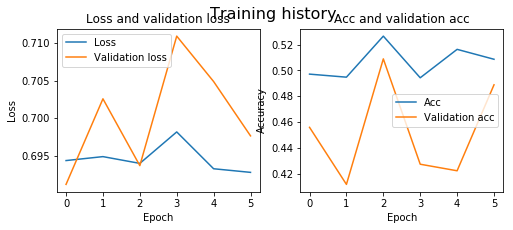

In [20]:
plt.figure(1, figsize=(8,3))
plt.subplot(121)
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title("Loss and validation loss")
plt.legend(["Loss", "Validation loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(122)
plt.plot(training.history['acc'])
plt.plot(training.history['val_acc'])
plt.title("Acc and validation acc")
plt.legend(["Acc", "Validation acc"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.suptitle('Training history', fontsize=16)
plt.show()

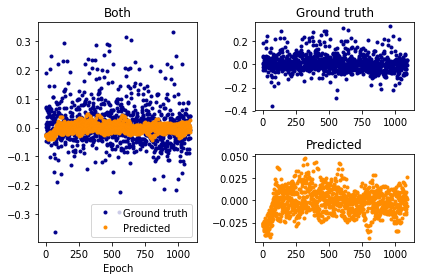

In [21]:
def predict_on_test():
    # Predict on last test data
    pred_size=1000
    pred_idx = test_idx.tail(pred_size + ModelFactory.look_back)
    y_pred, y_test = predictor.predict_idx(pred_idx, market_train_df, news_train_df)

    # Plot
    ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=2)
    ax1.plot(y_test, linestyle='none', marker='.', color='darkblue')
    ax1.plot(y_pred, linestyle='none', marker='.', color='darkorange')
    ax1.legend(["Ground truth","Predicted"])
    ax1.set_title("Both")
    ax1.set_xlabel("Epoch")
    ax2 = plt.subplot2grid((2, 2), (0, 1), colspan=1,rowspan=1)
    ax2.plot(y_test, linestyle='none', marker='.', color='darkblue')
    ax2.set_title("Ground truth")
    ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1,rowspan=1)
    ax3.plot(y_pred, linestyle='none', marker='.', color='darkorange')
    ax3.set_title("Predicted")
    plt.tight_layout()
    plt.show()

predict_on_test()

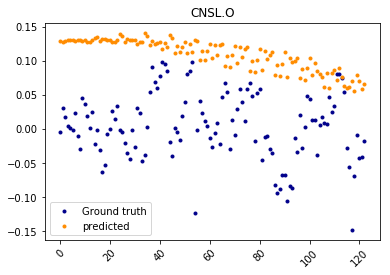

In [22]:
def predict_random_asset():
    """
    Get random asset from test set, predict on it, plot ground truth and predicted value
    """
    # Get any asset
    asset = test_idx['assetCode'].sample(1, random_state=66).values[0]
    pred_idx = test_idx[test_idx.assetCode == asset]
    y_pred, y_test = predictor.predict_idx(pred_idx, market_train_df, news_train_df)
    # Plot
    plt.plot(y_test, linestyle='none', marker='.', color='darkblue')
    plt.plot(y_pred, linestyle='none', marker='.', color='darkorange')
    plt.xticks(rotation=45)
    plt.title(asset)
    plt.legend(["Ground truth", "predicted"])
    plt.show()
    
predict_random_asset()

In [23]:
def get_score():
    """
    Calculation of actual metric that is used to calculate final score
    @param r: returnsOpenNextMktres10
    @param u: universe
    where rti is the 10-day market-adjusted leading return for day t for instrument i, and uti is a 0/1 universe variable (see the data description for details) that controls whether a particular asset is included in scoring on a particular day.    
    """
    # Get test sample to calculate score on
    pred_idx = test_idx #.sample(10000, random_state=24)
    y_pred, y_test = predictor.predict_idx(pred_idx, market_train_df, news_train_df)    
    look_back=ModelFactory.look_back
    market_df = market_train_df.loc[pred_idx.index]
    r=market_df['returnsOpenNextMktres10'].values#.values[look_back:]
    u=market_df['universe'].values#.values[look_back:]
    confidence=y_pred
    
    # calculation of actual metric that is used to calculate final score
    r = r.clip(-1,1) # get rid of outliers. Where do they come from??
    x_t_i = confidence.reshape(r.shape) * r * u

    #print(x_t_i.iloc[0])
    d = (market_df['time'].dt.day).values #[look_back:]
    data = {'day' : d, 'x_t_i' : x_t_i}
    df = pd.DataFrame(data)
    x_t = df.groupby('day').sum().values.flatten()
    mean = np.mean(x_t)
    std = np.std(x_t)
    score = mean / std
    return score
    
print(f"Sigma score: {get_score()}")

Sigma score: 0.3757048339479961


Accuracy: 0.505500
Predictions size:  10000
y_test size: 10000


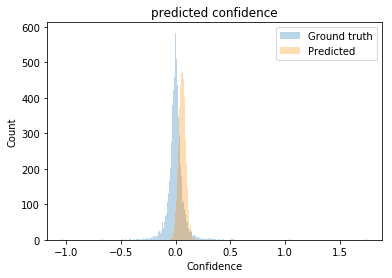

In [24]:
def calc_acc():
    # Get X_test, y_test with look back for LSTM
    pred_idx = test_idx.sample(10000)
    y_pred, y_test = predictor.predict_idx(pred_idx, market_train_df, news_train_df)
    
    #y_pred = pd.DataFrame(market_prepro.y_scaler.inverse_transform(model.predict(X_test)))
    print("Accuracy: %f" % accuracy_score(y_test >= 0, y_pred >= 0))
    #score = get_score(market_df, confidence, market_df.returnsOpenNextMktres10, market_df.universe)
    print('Predictions size: ', len(y_pred))
    print('y_test size:', len(y_test))
     # Show distribution of confidence that will be used as submission
    plt.hist(y_test, bins='auto', alpha=0.3)
    plt.hist(y_pred, bins='auto', alpha=0.3, color='darkorange')
    plt.legend(['Ground truth', 'Predicted'])
    plt.xlabel("Confidence")
    plt.ylabel("Count")
    plt.title("predicted confidence")
    plt.show()

# Call accuracy calculation and plot    
calc_acc()

In [25]:
def make_predictions(market_obs_df, news_obs_df, predictions_template_df):
    """
    Predict confidence for one day and update predictions_template_df['confidenceValue']
    @param market_obs_df: market_obs_df returned from env
    @param predictions_template_df: predictions_template_df returned from env.
    @return: None. prediction_template_df updated instead. 
    """
    # Predict
    y_pred = predictor.predict(market_obs_df, news_obs_df)
    confidence_df=pd.DataFrame(y_pred, columns=['confidence'])

    # Merge predicted confidence to predictions template
    pred_df = pd.concat([predictions_template_df, confidence_df], axis=1).fillna(0)
    predictions_template_df.confidenceValue = pred_df.confidence

In [26]:
# Save data here for later debugging on it
days_saved_data = []

# Store execution info for plotting later
predicted_days=[]
predicted_times=[]
last_predictions_template_df = None

# Predict day by day
days = env.get_prediction_days()
last_year=None
for (market_obs_df, news_obs_df, predictions_template_df) in days:
    # Store the data for later debugging on it
    days_saved_data.append((market_obs_df, news_obs_df, predictions_template_df))
    # For later plotting
    predicted_days.append(market_obs_df.iloc[0].time.strftime('%Y-%m-%d'))
    time_start = time()
    # For logging
    cur_year = market_obs_df.iloc[0].time.strftime('%Y')
    if cur_year != last_year:
        print(f'Predicting {cur_year}...')
        last_year = cur_year

    # Call prediction func
    make_predictions(market_obs_df, news_obs_df, predictions_template_df)
    #!!!
    env.predict(predictions_template_df)
    
    # For later plotting
    last_predictions_template_df = predictions_template_df
    predicted_times.append(time()-time_start)
    #print("Prediction completed for ", predicted_days[-1])
    
print(f"Prediction for {len(predicted_days)} days completed")

Predicting 2017...
Predicting 2018...
Predicting 2019...
Prediction for 634 days completed


In [27]:
# We've got a submission file!
# !!! Write submission after all days are predicted
env.write_submission_file()
print([filename for filename in os.listdir('.') if '.csv' in filename])

Your submission file has been saved. Once you `Commit` your Kernel and it finishes running, you can submit the file to the competition from the Kernel Viewer `Output` tab.
['twosigmanews.csv']
